In [1]:
# GPU scaling lidDrivenCavity
# comparison OF + DIC vs GKO and var. preconditioner
import matplotlib.pyplot as plt
import numpy as np
from import_benchmark_data import import_results
from helpers import idx_query, idx_keep_only, compute_speedup

plt.rcParams.update({'font.size': 18})

No Salvia installation found
Owls Version: 0.10.0-26-g31283c0
Warning no matplotlib support


In [3]:
def line_plot(df, x, columns, facet, properties, 
              fig, axes, kind="line", x_label=None, 
              facet_is_legend=False,
              default_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
             ):
    lines = list(set(df.index.get_level_values(facet)))
    lines.sort()
    for i, q in enumerate(columns):
        for j,line in enumerate(lines):
            sel = df[df.index.get_level_values(facet) == line]
            sel = idx_keep_only(sel,  keep=[x])
            ax = axes[i]
            legends = properties.get("legends")
            legend = line  if facet_is_legend else False
            f = sel.sort_index().plot(
                legend=True,
                label=legend,
                lw=3,
                ms=10,
                kind=kind,
                ax=ax,
                linestyle=properties.get("linestyle", lambda x: "-")(line),
                marker=properties["marker"](line),
                color=properties.get("color", lambda x: default_colors[j])(line),
            )
            if x_label:
                ax.set_xlabel(x_label[i])
            if legends:
                plt.legend(legends)

# Speedup
## vs Single Node

In [43]:
revision = "93635822"
#revision_prev = "0e258ede"
case = "scaling"
path = "../../results/{}/lidDrivenCavity/".format(revision)

In [6]:
def calc_nodes(df, sel, masks):
    df["nodes"] = df.index.get_level_values('mpi_ranks')
    for sel_value, value in masks:
        mask = df.index.get_level_values(sel) == sel_value
        df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/value
    df = df.set_index("nodes", append=True)
    return df

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


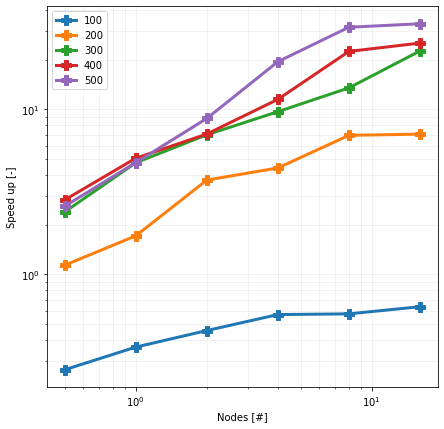

In [44]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)

df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])


of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

                    
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        ax.set_yscale('log')
        ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

## vs Single Node CUDA

'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


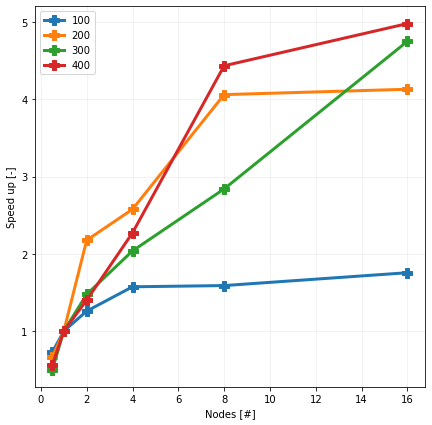

In [7]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False)
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "CUDA")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

           
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')

../../results/f77f2437/lidDrivenCavity/simple/Logs


../../results/f77f2437/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


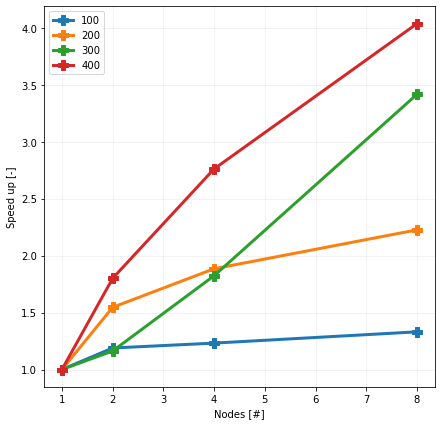

In [46]:
revision = "f77f2437"
#revision_prev = "0e258ede"
case = "simple"
path = "../../results/{}/lidDrivenCavity/".format(revision)


df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka",
        "login": "perlmutter"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "perlmutter", True),
            ("resolution", 500, False)
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp", "case"] ,axis=1)
df = calc_nodes(df, "executor_p", [("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "CUDA")
        ],
        drop_indices=["node", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

           
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')

In [43]:
df

run_time  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node processes mpiRank_gko nodes                
CG       HIP        NoPrecond        200        None        4         nla  1         4.0         4.0     196.156270   
                                                            8         nla  1         8.0         8.0     108.191993   
                                                            2         nla  1         2.0         2.0     398.435820   
                                     300        None        4         nla  1         4.0         4.0     916.530221   
                                                            8         nla  1         8.0         8.0     434.179688   
                                                            2         nla  1         2.0         2.0    1890.796229   
                                     500        None        0         nla  1         4.0         0.0       0.000000   
                                                                                     8.0         0.0       0.000000   
                                                                                     2.0         0.0       0.000000   
                                     400        None        4         nla  1         4.0         4.0    4180.525962   
                                                            8         nla  1         8.0         8.0    1363.234594   
                                                            2         nla  1         2.0         2.0    7669.231584   
                                     100        None        4         nla  1         4.0         4.0      22.560062   
                                                            8         nla  1         8.0         8.0      15.915154   
                                                            2         nla  1         2.0         2.0      41.030479   

                                                                                                        linear_solve_p  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node processes mpiRank_gko nodes                   
CG       HIP        NoPrecond        200        None        4         nla  1         4.0         4.0      1.918129e+06   
                                                            8         nla  1         8.0         8.0      1.342818e+06   
                                                            2         nla  1         2.0         2.0      3.309437e+06   
                                     300        None        4         nla  1         4.0         4.0      7.664973e+06   
                                                            8         nla  1         8.0         8.0      4.369141e+06   
                                                            2         nla  1         2.0         2.0      1.449130e+07   
                                     500        None        0         nla  1         4.0         0.0      0.000000e+00   
                                                                                     8.0         0.0      0.000000e+00   
                                                                                     2.0         0.0      0.000000e+00   
                                     400        None        4         nla  1         4.0         4.0      5.029153e+07   
                                                            8         nla  1         8.0         8.0      1.220309e+07   
                                                            2         nla  1         2.0         2.0      7.411607e+07   
                                     100        None        4         nla  1         4.0         4.0      2.744592e+05   
                                                            8         nla  1         8.0         8.0      2.219750e+05   
                                                            2         nla  1         2.0         2.0      4.010918e+05   

        

../../results/f77f2437/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


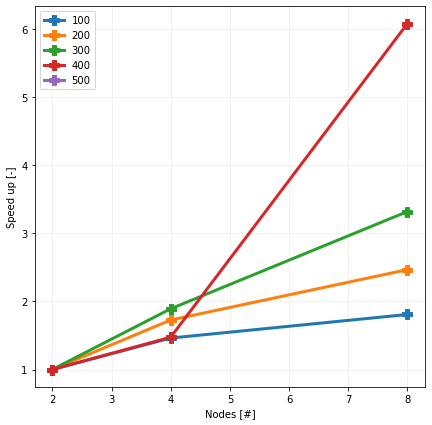

In [44]:
revision = "f77f2437"
#revision_prev = "0e258ede"
case = "simple"
path = "../../results/{}/lidDrivenCavity/".format(revision)


df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka",
        "login14": "perlmutter"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "nla", True),
            #("resolution", 500, False)
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp", "case"] ,axis=1)
df = calc_nodes(df, "executor_p", [("HIP", 1)])

of_data = compute_speedup(df,
        [("nodes", 2.0),
         ("executor_p", "HIP")
        ],
        drop_indices=["node", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "HIP"),    
    ]).sort_index()

           
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')

## vs Multinode

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


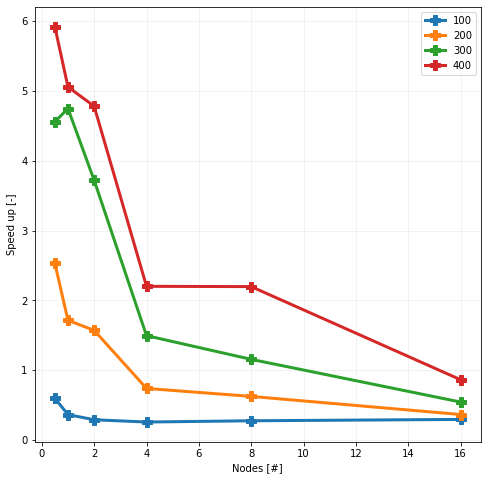

In [45]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(8 * len(columns), 8),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False)
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])


of_data = compute_speedup(df,
        [("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )


gko_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()


line_plot(gko_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})


for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")        
        
plt.savefig(path + case + "/linear_solve_multi_gpu.png", bbox_inches='tight')

## Per Iter

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


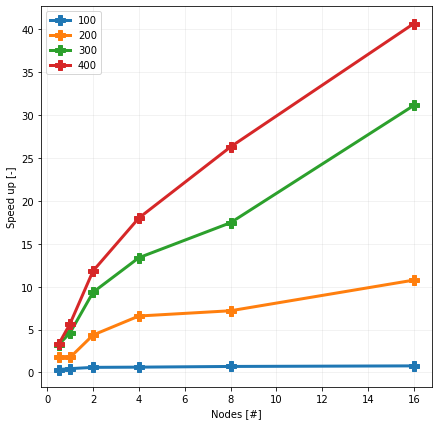

In [46]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])


of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

 
line_plot(of_data["linear_solve_p_per_iter"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + case +  "/linear_solve_p_per_iter_multi_gpu_vs_single_node.png", bbox_inches='tight')

# Energy Consumption

## Relative vs Single CPU Node

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


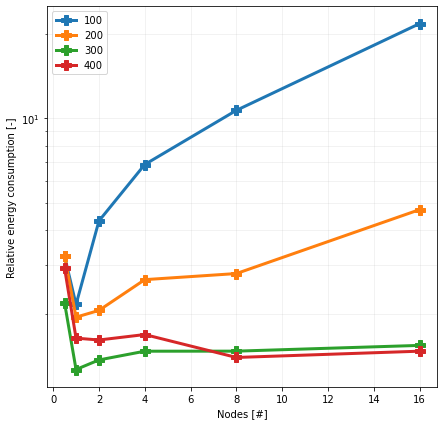

In [47]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Relative energy consumption [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),
        ("nodes", 0.25, False),
    ]).sort_index()

       
of_data["EnergyConsumed"] = 1/of_data["EnergyConsumed"]    
line_plot(of_data["EnergyConsumed"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        ax.set_yscale('log')

plt.savefig(path + case + "/energy_consumption_multi_gpu_vs_single_node.png", bbox_inches='tight')

## Relative vs Multi CPU Node

'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


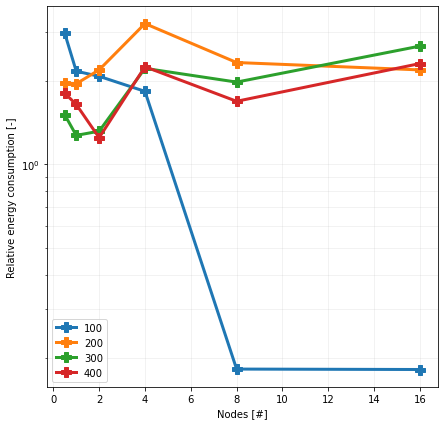

In [48]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Relative energy consumption [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = compute_speedup(df,
        [("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),
        ("nodes", 0.25, False),
    ]).sort_index()

       
of_data["EnergyConsumed"] = 1/of_data["EnergyConsumed"]

line_plot(of_data["EnergyConsumed"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        ax.set_yscale('log')

plt.savefig(path + case + "/energy_consumption_multi_gpu_vs_multi_node.png", bbox_inches='tight')

## Absolute Energy Consumption OF and GKO

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


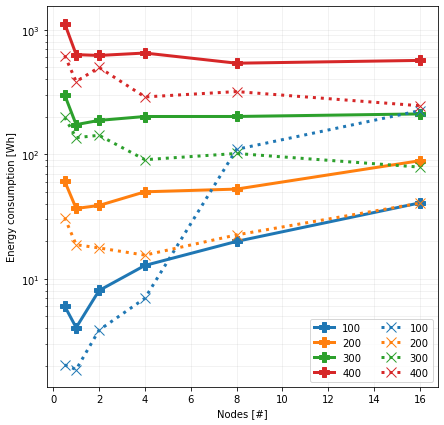

In [49]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Energy consumption [Wh]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = idx_query(df, [
        ("executor_p", "DefaultOF"),
        ("nodes", 0.25, False),
        ("nodes", 64, False),
        ("nodes", 32, False),
    ]).sort_index()

gko_data = idx_query(df, [
        ("executor_p", "CUDA"),
        ("nodes", 0.25, False),
    ]).sort_index()


for data, marker, linestyle in [(gko_data,"P","-"), (of_data, "x", ":")]:
    line_plot(data["EnergyConsumed"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        #"legends": ["8M", "17M", "34M"],
        "linestyle": lambda x: linestyle,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })


for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        ax.set_yscale('log')

plt.legend(ncol=2)#, loc="top center")

plt.savefig(path + case + "/energy_consumption_gko_of_multi_gpu_vs_multi_node.png", bbox_inches='tight')

# Number of Iterations

## Absolute OF and GKO

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


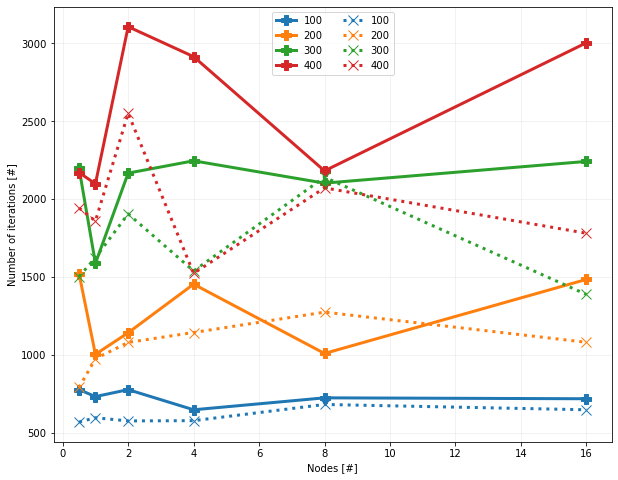

In [50]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(10 * len(columns), 8),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Number of iterations [#]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

gko_data = idx_query(df, [
        ("executor_p", "CUDA"),
        ("nodes", 0.25, False),

    ]).sort_index()

of_data = idx_query(df, [
        ("executor_p", "DefaultOF"),
        ("nodes", 64, False),
        ("nodes", 32, False),
        ("nodes", 0.25, False),
    ]).sort_index()


for data, marker, linestyle in [(gko_data,"P","-"), (of_data, "x", ":")]:
    line_plot(data["number_iterations_p"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        #"legends": ["8M", "17M", "34M"],
        "linestyle": lambda x: linestyle,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })


for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")        

plt.legend(ncol=2)#, loc="top center")
plt.savefig(path + case + "/number_iterations_multi_gpu_of_and_gko.png", bbox_inches='tight')

## Relative

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


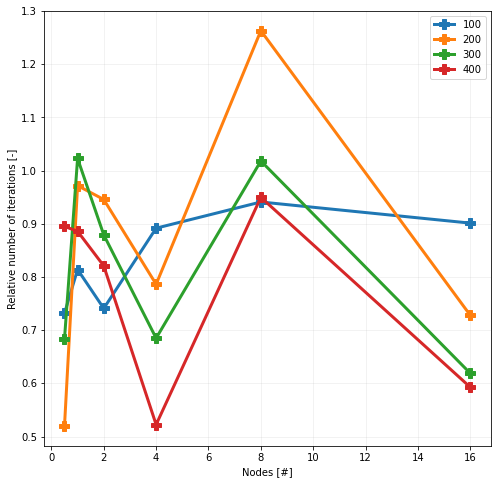

In [51]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(8 * len(columns), 8),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Relative number of iterations [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False)
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = compute_speedup(df,
        [("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )


gko_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

                    
line_plot(gko_data["number_iterations_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})


for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")        
        
plt.savefig(path + case + "/relative_number_iterations_multi_gpu_of_and_gko.png", bbox_inches='tight')

## Absolut GKO Only

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


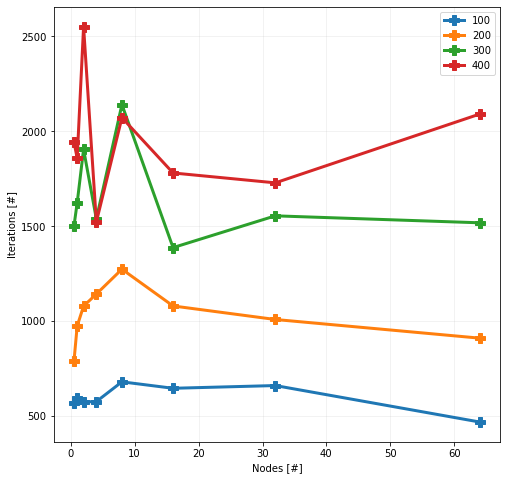

In [52]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(8 * len(columns), 8),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Iterations [#]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

gko_data = idx_query(df, [
        ("executor_p", "DefaultOF"),    
    ]).sort_index()


line_plot(gko_data["number_iterations_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})


for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")        
        
plt.savefig(path + case + "/iterations_multi_gpu.png", bbox_inches='tight')

# Overhead

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


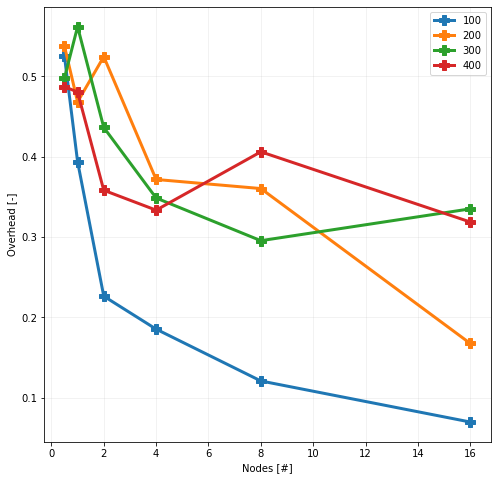

In [53]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(8 * len(columns), 8),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Overhead [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False)
        ])


df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

gko_data = idx_query(df, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

gko_data["overhead"] = 1-(gko_data["gko_solve"]/gko_data["linear_solve_p"])


line_plot(gko_data["overhead"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})


for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")        
        
plt.savefig(path + case + "/overhead_solve_multi_gpu.png", bbox_inches='tight')

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


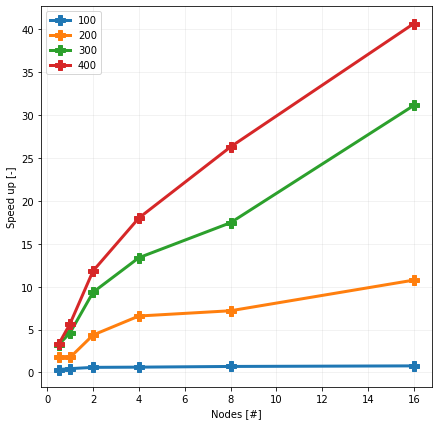

In [54]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
           # ("resolution", b)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])


of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

line_plot(of_data["linear_solve_p_per_iter"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + case +  "/linear_solve_p_per_iter_multi_gpu_vs_single_node.png", bbox_inches='tight')

# Parallel Efficiency

../../results/93635822/lidDrivenCavity/scaling/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


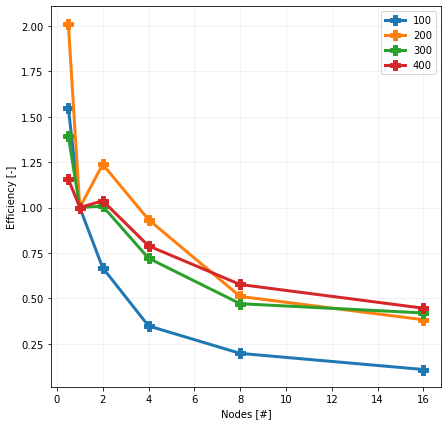

In [59]:

df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Efficiency [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
           # ("resolution", b)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df["nodes"] = df.index.get_level_values('mpi_ranks')
df["gpus"] = df.index.get_level_values("mpiRank_gko")

df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "CUDA")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data["efficiency_linear_solve_p_per_iter"] = of_data["linear_solve_p_per_iter"]*of_data["gpus"]

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

              
line_plot(of_data["efficiency_linear_solve_p_per_iter"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + "/efficiency_solve_p_per_iter_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')

# Simple DD

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


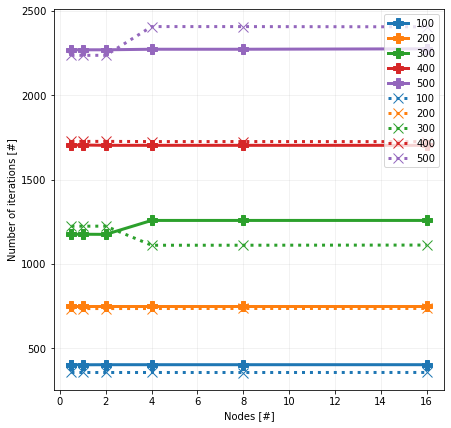

In [64]:
revision = "f66ef73d"
path = "../../results/{}/lidDrivenCavity/".format(revision)
case = "simple"

df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Number of iterations [#]")

axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])

of_data = idx_query(df, [
        ("executor_p", "DefaultOF"),
        ("nodes", 0.25, False),
        ("nodes", 64, False),
        ("nodes", 32, False),
    ]).sort_index()

gko_data = idx_query(df, [
        ("executor_p", "CUDA"),
        ("nodes", 0.25, False),
    ]).sort_index()


for data, marker, linestyle in [(gko_data,"P","-"), (of_data, "x", ":")]:      
    line_plot(data["number_iterations_p"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "linestyle": lambda x: linestyle,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + case +  "/linear_solve_p_per_iter_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


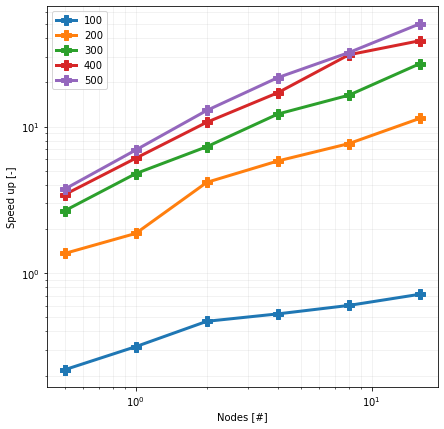

In [65]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

    
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        ax.set_yscale('log')
        ax.set_xscale('log')


plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node_simple.png", bbox_inches='tight')

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


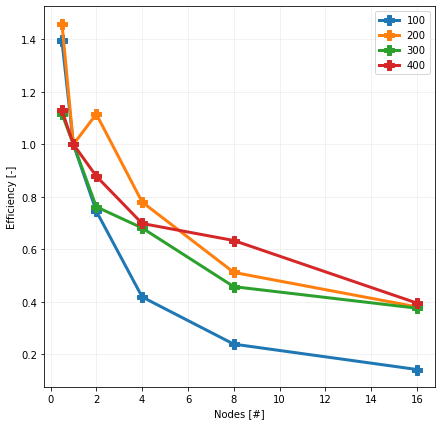

In [68]:

df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Efficiency [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
           # ("resolution", b)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df["nodes"] = df.index.get_level_values('mpi_ranks')
df["gpus"] = df.index.get_level_values("mpiRank_gko")

df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "CUDA")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data["efficiency_linear_solve_p_per_iter"] = of_data["linear_solve_p_per_iter"]*of_data["gpus"]

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

              
line_plot(of_data["efficiency_linear_solve_p_per_iter"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + "/efficiency_solve_p_per_iter_multi_gpu_vs_single_node_CUDA_simple.png", bbox_inches='tight')

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


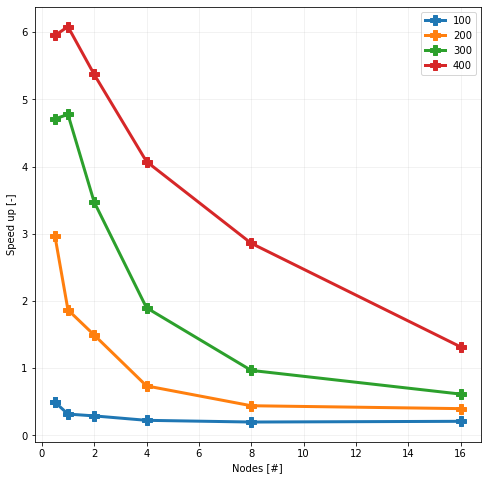

In [67]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(8 * len(columns), 8),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])

of_data = compute_speedup(df,
        [("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )


gko_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

                    
line_plot(gko_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})


for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")        
        
plt.savefig(path + case + "/linear_solve_multi_gpu_simple.png", bbox_inches='tight')

In [36]:
df.loc["CG"].

run_time  \
executor_p preconditioner_p resolution omp_threads mpi_ranks node   mpiRank_of processes mpiRank_gko nodes                 
CUDA       NoPrecond        500        1           2         horeka 0.0        1         0.5         0.500000          0   
                                                   4         horeka 0.0        1         1.0         1.000000          0   
                                                   16        horeka 0.0        1         4.0         4.000000          0   
                                                   64        horeka 0.0        1         16.0        16.000000         0   
                                                   32        horeka 0.0        1         8.0         8.000000          0   
...                                                                                                                  ...   
DefaultOF  NoPrecond        100        1           1024      horeka 16.0       1         0.0         13.473684         0   
                                                   128       horeka 2.0        1         0.0         1.684211          0   
                                                   64        horeka 1.0        1         0.0         0.842105          0   
                                                   32        horeka 0.5        1         0.0         0.421053          0   
                                                   256       horeka 4.0        1         0.0         3.368421          0   

                                                                                                                linear_solve_p  \
executor_p preconditioner_p resolution omp_threads mpi_ranks node   mpiRank_of processes mpiRank_gko nodes                       
CUDA       NoPrecond        500        1           2         horeka 0.0        1         0.5         0.500000     6.539169e+07   
                                                   4         horeka 0.0        1         1.0         1.000000     3.537864e+07   
                                                   16        horeka 0.0        1         4.0         4.000000     1.134925e+07   
                                                   64        horeka 0.0        1         16.0        16.000000    4.872173e+06   
                                                   32        horeka 0.0        1         8.0         8.000000     7.658534e+06   
...                                                                                                                        ...   
DefaultOF  NoPrecond        100        1           1024      horeka 16.0       1         0.0         13.473684    2.161732e+04   
                                                   128       horeka 2.0        1         0.0         1.684211     4.594968e+04   
                                                   64        horeka 1.0        1         0.0         0.842105     7.489887e+04   
                                                   32        horeka 0.5        1         0.0         0.421053     1.684101e+05   
                                                   256       horeka 4.0        1         0.0         3.368421     3.152621e+04   

                                                                                                                linear_solve_U  \
executor_p preconditioner_p resolution omp_threads mpi_ranks node   mpiRank_of processes mpiRank_gko nodes                       
CUDA       NoPrecond        500        1           2         horeka 0.0        1         0.5         0.500000     8.479342e+07   
                                                   4         horeka 0.0        1         1.0         1.000000     4.470540e+07   
                                                   16        horeka 0.0        1         4.0         4.000000     1.099905e+07   
                                                   64        horeka 0.0        1         16.0        16.000000    2.710387e+06   
                            

In [88]:
import pandas as pd
import numpy as np
import matplotlib as mpl

df = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, np.nan],[19, 439, 6, 452, 226,232]],
                  index=pd.Index(['Tumour (Positive)', 'Non-Tumour (Negative)'], name='Actual Label:'),
                  columns=pd.MultiIndex.from_product([['Decision Tree', 'Regression', 'Random'],['Tumour', 'Non-Tumour']], names=['Model:', 'Predicted:']))
s = df.style.format('{:.0f}') #.hide([('Random', 'Tumour'), ('Random', 'Non-Tumour')], axis="columns")

s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
])
cell_color = pd.DataFrame([['true ', 'false ', 'true ', 'false '],
                           ['false ', 'true ', 'false ', 'true ']],
                          index=df.index,
                          columns=df.columns[:4])
s.set_td_classes(cell_color)

AttributeError: 'Styler' object has no attribute 'set_td_classes'